In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [32]:
BITCOIN_COMISSION = 0.02
GOLD_COMISSION = 0.01
BITCOIN_COMISSIONS = [0.01, 0.02, 0.04]
FACTORS = [1, 2, 3, 4]


In [39]:
df = pd.read_csv("Data/final_prediction.csv")

In [28]:
def profit_max(C,B,G,q_b,q_g,alpha_b,alpha_g):

    positions = []

    # set the objects of the optimization function
    obj=[alpha_b - q_b, alpha_g - q_g]
    
    A_ub = [[alpha_b + 1, alpha_g + 1]]
    b_ub = [C + B * (1 + alpha_b) + G * (1 +alpha_g)]

    # set the bound for our variable
    bnd = [(B, float("inf")),  # Bounds of \hat{B_{d+x}}
           (G, float("inf"))]  # Bounds of \hat{G_{d+x}}
    
    # invoke the function
    strategy = linprog(c=obj, A_ub=A_ub, b_ub=b_ub, bounds=bnd,
                       method="revised simplex")
    positions.append(strategy.x)

    # set the objects of the optimization function
    obj = [-alpha_b - q_b, alpha_g - q_g]

    A_ub = [[-alpha_b + 1, alpha_g + 1]]
    b_ub = [C + B * (1 - alpha_b) + G * (1 + alpha_g)]

    # set the bound for our variable
    bnd = [(0, B),  # Bounds of \hat{B_{d+x}}
           (G, float("inf"))]  # Bounds of \hat{G_{d+x}}

    # invoke the function
    strategy = linprog(c=obj, A_ub=A_ub, b_ub=b_ub, bounds=bnd,
                       method="revised simplex")
    positions.append(strategy.x)

    # set the objects of the optimization function
    obj = [alpha_b - q_b, -alpha_g - q_g]

    A_ub = [[alpha_b + 1, -alpha_g + 1]]
    b_ub = [C + B * (1 + alpha_b) + G * (1 - alpha_g)]

    # set the bound for our variable
    bnd = [(B, float("inf")),  # Bounds of \hat{B_{d+x}}
           (0, G)]  # Bounds of \hat{G_{d+x}}

    # invoke the function
    strategy = linprog(c=obj, A_ub=A_ub, b_ub=b_ub, bounds=bnd,
                       method="revised simplex")
    positions.append(strategy.x)

    # set the objects of the optimization function
    obj = [-alpha_b - q_b, -alpha_g - q_g]

    A_ub = [[-alpha_b + 1, -alpha_g + 1]]
    b_ub = [C + B * (1 - alpha_b) + G * (1 - alpha_g)]

    # set the bound for our variable
    bnd = [(0, B),  # Bounds of \hat{B_{d+x}}
           (0, G)]  # Bounds of \hat{G_{d+x}}

    # invoke the function
    strategy = linprog(c=obj, A_ub=A_ub, b_ub=b_ub, bounds=bnd,
                       method="revised simplex")
    positions.append(strategy.x)

    return positions

In [3]:
def calc_pos_and_new_C(C,B,G,q_b,q_g,alpha_b,alpha_g,B_hat,G_hat):
    new_C = C - abs(B_hat - B) * alpha_b - abs(G_hat - G) * alpha_g - (B_hat - B) - (G_hat - G)
    pos = new_C + B_hat * (1 + q_b) + G_hat * (1 + q_g)
    return pos, new_C

In [34]:
def clean_buy_sell(buy, sell):
    n_buy = [buy[0]]
    n_sell = []
    buy_idx = 0
    sell_idx = 0
    while sell_idx < len(sell) and sell[sell_idx] < buy[0]:
        sell_idx += 1
    buying = False
    while buy_idx < len(buy) and sell_idx < len(sell):
        if buy[buy_idx] < sell[sell_idx]:
            if buying:
                n_buy.append(buy[buy_idx])
                buying = False
            buy_idx += 1
        else:
            if not buying:
                n_sell.append(sell[sell_idx])
                buying = True
            sell_idx += 1
    if buying and buy_idx < len(buy):
        n_buy.append(buy[buy_idx])
    elif not buying and sell_idx < len(sell):
        n_sell.append(sell[sell_idx])
    return n_buy, n_sell


In [54]:
def calc_final_position(buy, sell):
    position = 1000
    trace = []
    for i in range(len(buy)):
        if i == len(buy) - 1:
            if len(sell) == len(buy):
                position *= (1 - BITCOIN_COMISSION) ** 2 * \
                    df["Value"][sell[i]] / df["Value"][buy[i]]
                # trace.append([df["Date"][sell[i]], position])
            else:
                position *= (1 - BITCOIN_COMISSION) * \
                    df["Value"].iloc[-1] / df["Value"][buy[i]]
                # trace.append([df["Date"][sell[i]], position])
        else:
            position *= (1 - BITCOIN_COMISSION) ** 2 * \
                df["Value"][sell[i]] / df["Value"][buy[i]]
    return position


In [40]:
profits = []
# for bitcoin_comission in BITCOIN_COMISSIONS:
for bitcoin_comission in BITCOIN_COMISSIONS:
    profit_row = []
    for consider_factor in FACTORS:
        if consider_factor == 1:
            sell = df[(df["Bitcoin % Final Prediction (1 Days)"] < -bitcoin_comission)].index
            buy = df[(
                df["Bitcoin % Final Prediction (1 Days)"] > bitcoin_comission)].index
        elif consider_factor == 2:
            sell = df[(df["Bitcoin % Final Prediction (1 Days)"] < 0) &
                      (df["Bitcoin % Final Prediction (3 Days)"] < 0) &
                      ((df["Bitcoin % Final Prediction (1 Days)"] < -bitcoin_comission) &
                       (df["Bitcoin % Final Prediction (3 Days)"] < -bitcoin_comission))].index
            buy = df[(df["Bitcoin % Final Prediction (1 Days)"] > 0) &
                    (df["Bitcoin % Final Prediction (3 Days)"] > 0) &
                    ((df["Bitcoin % Final Prediction (1 Days)"] > bitcoin_comission) &
                    (df["Bitcoin % Final Prediction (3 Days)"] > bitcoin_comission))].index
        elif consider_factor == 3:
            sell = df[(df["Bitcoin % Final Prediction (1 Days)"] < 0) &
                      (df["Bitcoin % Final Prediction (3 Days)"] < 0) &
                      (df["Bitcoin % Final Prediction (5 Days)"] < 0) &
                      ((df["Bitcoin % Final Prediction (1 Days)"] < -bitcoin_comission) &
                       (df["Bitcoin % Final Prediction (3 Days)"] < -bitcoin_comission) &
                       (df["Bitcoin % Final Prediction (5 Days)"] < -bitcoin_comission))].index
            buy = df[(df["Bitcoin % Final Prediction (1 Days)"] > 0) &
                     (df["Bitcoin % Final Prediction (3 Days)"] > 0) &
                     (df["Bitcoin % Final Prediction (5 Days)"] > 0) &
                     ((df["Bitcoin % Final Prediction (1 Days)"] > bitcoin_comission) &
                     (df["Bitcoin % Final Prediction (3 Days)"] > bitcoin_comission) &
                     (df["Bitcoin % Final Prediction (5 Days)"] > bitcoin_comission))].index
        else:
            sell = df[(df["Bitcoin % Final Prediction (1 Days)"] < 0) &
                      (df["Bitcoin % Final Prediction (3 Days)"] < 0) &
                      (df["Bitcoin % Final Prediction (5 Days)"] < 0) &
                      (df["Bitcoin % Final Prediction (10 Days)"] < 0) &
                      ((df["Bitcoin % Final Prediction (1 Days)"] < -bitcoin_comission) &
                       (df["Bitcoin % Final Prediction (3 Days)"] < -bitcoin_comission) &
                       (df["Bitcoin % Final Prediction (5 Days)"] < -bitcoin_comission) &
                          (df["Bitcoin % Final Prediction (10 Days)"] < -bitcoin_comission))].index
            buy = df[(df["Bitcoin % Final Prediction (1 Days)"] > 0) &
                     (df["Bitcoin % Final Prediction (3 Days)"] > 0) &
                     (df["Bitcoin % Final Prediction (5 Days)"] > 0) &
                     (df["Bitcoin % Final Prediction (10 Days)"] > 0) &
                     ((df["Bitcoin % Final Prediction (1 Days)"] > bitcoin_comission) &
                     (df["Bitcoin % Final Prediction (3 Days)"] > bitcoin_comission) &
                     (df["Bitcoin % Final Prediction (5 Days)"] > bitcoin_comission) &
                     (df["Bitcoin % Final Prediction (10 Days)"] > bitcoin_comission))].index
        buy, sell = clean_buy_sell(buy, sell)
        final_pos = calc_final_position(buy, sell, df[["Data", "Value"]])
        print(f"Strategy with consider factor {consider_factor} and comission {bitcoin_comission}: ", final_pos)
        profit_row.append(round(final_pos, 2))

        
    profits.append(profit_row)
    # naive_buy, naive_sell = clean_buy_sell(naive_buy, naive_sell)

final_report = pd.DataFrame(profits, columns = FACTORS, index=BITCOIN_COMISSIONS)
final_report

Strategy with consider factor 1 and comission 0.01:  1279455.6761288343
Strategy with consider factor 2 and comission 0.01:  2624966.967701051
Strategy with consider factor 3 and comission 0.01:  2376976.4174703667
Strategy with consider factor 4 and comission 0.01:  1771741.3978203167
Strategy with consider factor 1 and comission 0.02:  466016.8786969816
Strategy with consider factor 2 and comission 0.02:  533322.619049659
Strategy with consider factor 3 and comission 0.02:  143047.84824616453
Strategy with consider factor 4 and comission 0.02:  128311.50352832238
Strategy with consider factor 1 and comission 0.04:  14953.633123615422
Strategy with consider factor 2 and comission 0.04:  12868.350354719223
Strategy with consider factor 3 and comission 0.04:  44764.8634586337
Strategy with consider factor 4 and comission 0.04:  44764.8634586337


,1,2,3,4
0.01,1279455.68,2624966.97,2376976.42,1771741.40
0.02,466016.88,533322.62,143047.85,128311.50
0.04,14953.63,12868.35,44764.86,44764.86


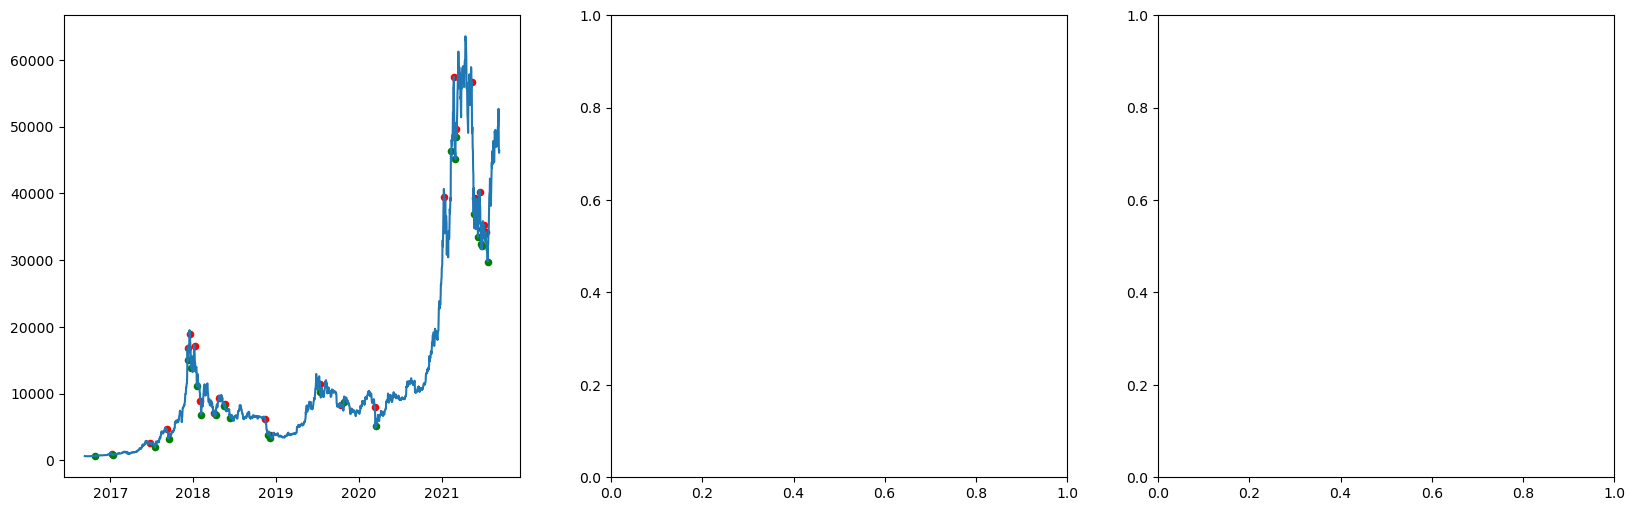

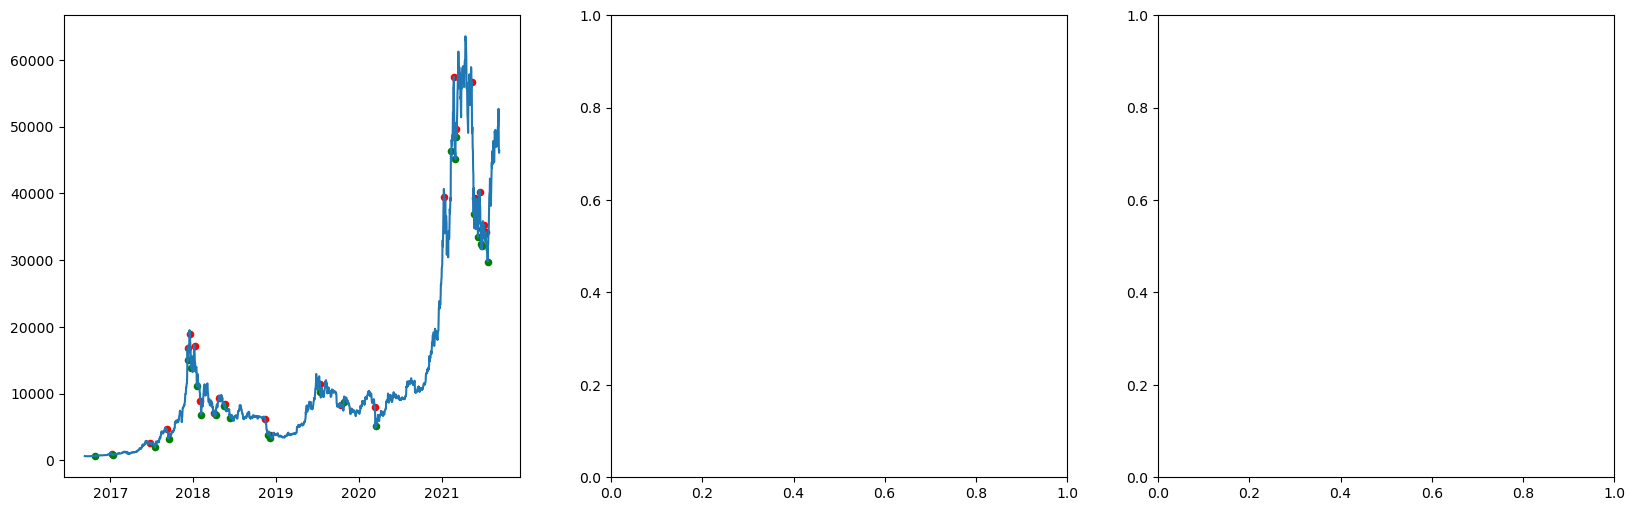

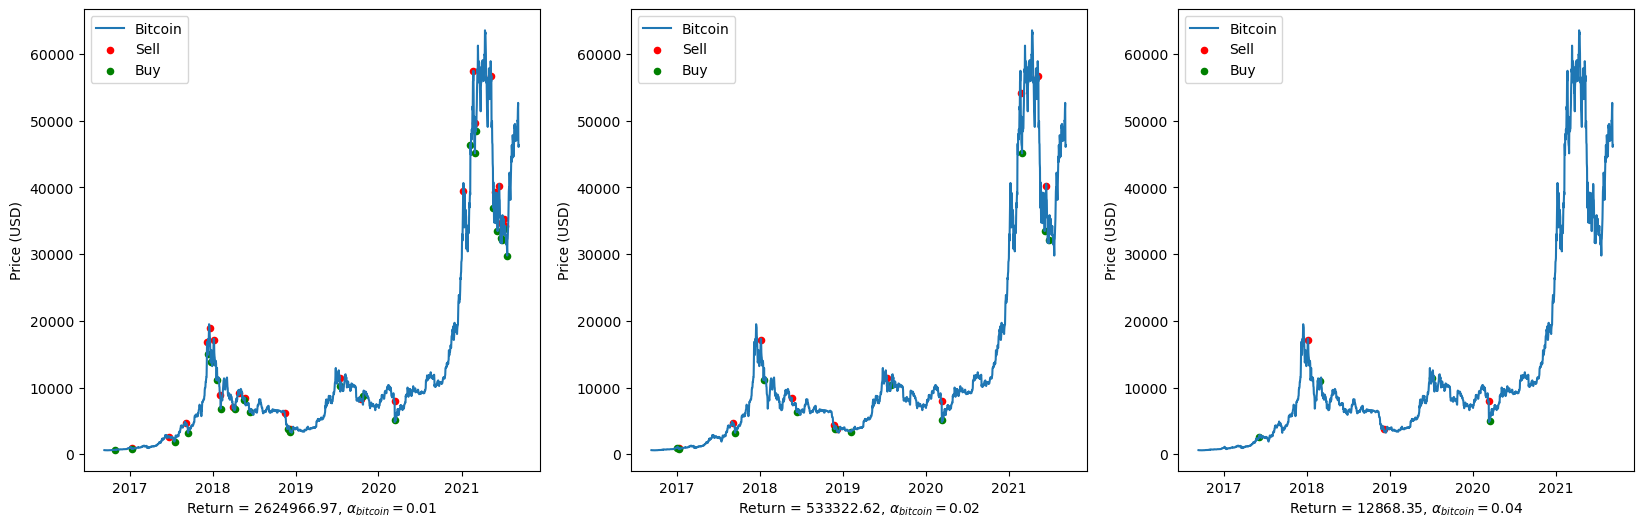

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i in range(len(BITCOIN_COMISSIONS)):

    sell = df[(df["Bitcoin % Final Prediction (1 Days)"] < 0) &
            (df["Bitcoin % Final Prediction (3 Days)"] < 0) &
            ((df["Bitcoin % Final Prediction (1 Days)"] < -BITCOIN_COMISSIONS[i]) &
             (df["Bitcoin % Final Prediction (3 Days)"] < -BITCOIN_COMISSIONS[i]))].index
    buy = df[(df["Bitcoin % Final Prediction (1 Days)"] > 0) &
            (df["Bitcoin % Final Prediction (3 Days)"] > 0) &
             ((df["Bitcoin % Final Prediction (1 Days)"] > BITCOIN_COMISSIONS[i]) &
              (df["Bitcoin % Final Prediction (3 Days)"] > BITCOIN_COMISSIONS[i]))].index

    buy, sell = clean_buy_sell(buy, sell)

    tmp = df[["Value"]]
    tmp = tmp.set_index(pd.to_datetime(df["Date"]))
    axs[i].plot(tmp, label="Bitcoin")
    axs[i].scatter(tmp.index[sell], tmp["Value"]
                   [sell], c="red", s=20, label="Sell")
    axs[i].scatter(tmp.index[buy], tmp["Value"][buy],
                   c="green", s=20, label="Buy")
    axs[i].set_xlabel(
        f"Return = ${calc_final_position(buy, sell):.2f}$, $\\alpha_{{bitcoin}}={BITCOIN_COMISSIONS[i]}$")
    axs[i].set_ylabel("Price (USD)")
    axs[i].legend()

plt.show()
